In [1]:
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
'''def viewImage(image, name_of_window):
    cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()'''
def viewImage(image):
    RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_im)
    plt.axis('off')
    plt.show()

загрузка и изменение размера

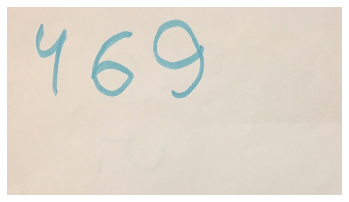

In [3]:
image = cv2.imread("8.png")
k = image.shape[0]/image.shape[1]
width = 1024
height = int(1024 * k)
dim = (width, height)
# resize image
image = cv2.resize(image, dim)
viewImage(image)

фильтрация

Threshold


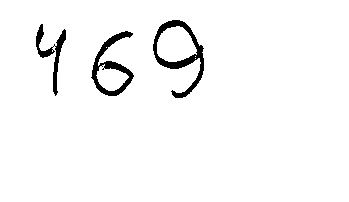

Dilate


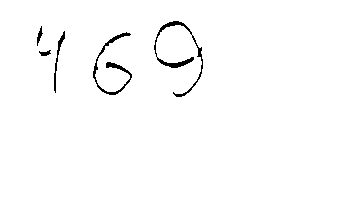

Erode


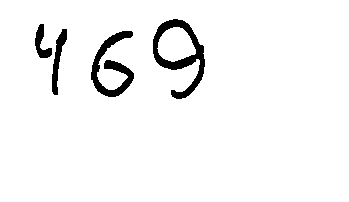

In [4]:
im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#ret, im = cv2.threshold(im, 110, 255, 0)
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 17)
print('Threshold')
viewImage(im)

kernel = np.ones((3,3),np.uint8)

im = cv2.dilate(im,kernel,iterations=3)
print('Dilate')
viewImage(im)

kernel = np.ones((3,3),np.uint8)
im = cv2.erode(im, kernel,iterations=5)
print('Erode')
viewImage(im)


Разделение на символы

удаление пустых строк сверху и снизу

In [5]:
def del_null_rows(im, bg_col = 255):
    null_row = [np.all(im[i,:] == bg_col) for i in range(im.shape[0])]
    if False in null_row:
        not_null_row_arg = null_row.index(False)
    else:
        not_null_row_arg = 0
    if False in list(reversed(null_row)):
        not_null_row_arg_end = list(reversed(null_row)).index(False)
        if not_null_row_arg_end == 0:
            not_null_row_arg_end = 1
    else:
        not_null_row_arg_end = 1
    im = im[not_null_row_arg:-not_null_row_arg_end,:]
    return im


удаление пустых столбцов

In [6]:
def del_null_cols(im, bg_col = 255):
    null_col = [np.all(im[:,i] == bg_col) for i in range(im.shape[1])]   
    if False in null_col:
        not_null_col_arg = null_col.index(False)
    else:
        not_null_col_arg = 0
    if False in list(reversed(null_col)):
        not_null_col_arg_end = list(reversed(null_col)).index(False)
        if not_null_col_arg_end == 0:
            not_null_col_arg_end = 1
    else:
        not_null_col_arg_end = 1
    im = im[:,not_null_col_arg:-not_null_col_arg_end]
    return im

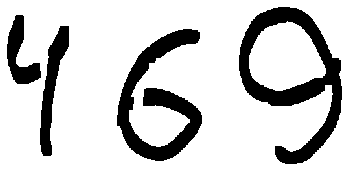

In [7]:
im = del_null_rows(im)
im = del_null_cols(im)
im.shape
viewImage(im)

разделение на символы

In [8]:
def split_nums(im):
    null_col = [np.all(im[:,i] == 255) for i in range(im.shape[1])] 
    space_n = int(im.shape[1]*0.01)
    space = [True for x in range(space_n)]
    nums = []
    while False in null_col:
        space_arg = -1
        for i in range(len(null_col)-space_n):
            if null_col[i:i+space_n] == space:
                space_arg = i
                break
        im = del_null_cols(im)
        im = del_null_rows(im)
        nums.append(im[:,:space_arg])
        im = im[:,space_arg:]
        null_col = [np.all(im[:,i] == 255) for i in range(im.shape[1])] 
    return nums

In [9]:
nums = split_nums(im)

приводим к квадратному виду и 28х28

In [10]:
def to_mnist(im):
    if 255 in im:
        im[im == 0] = 1
        im[im == 255] = 0
    im = del_null_cols(im,0)
    im = del_null_rows(im,0)
    if im.shape[0]>im.shape[1]:
        n = im.shape[0] - im.shape[1]
        field = np.zeros((im.shape[0], int(n/2)))
        im = np.concatenate((field, im, field), axis=1)
        if im.shape[0]!= im.shape[1]:
            im = np.concatenate((im, np.zeros((im.shape[0], 1))), axis=1)
    else: 
        n = im.shape[1] - im.shape[0]
        field = np.zeros((int(n/2),im.shape[1]))
        im = np.concatenate((field, im, field), axis=0)
        if im.shape[0]!= im.shape[1]:
            im = np.concatenate((im, np.zeros((1,im.shape[1]))), axis=0)
    im = cv2.resize(im, (28,28))
    return im


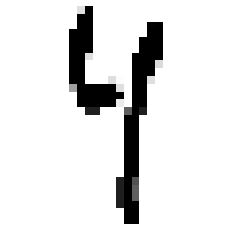

(28, 28)


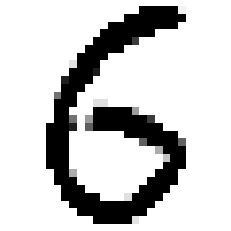

(28, 28)


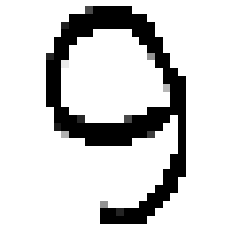

(28, 28)


In [11]:
nums28 = []
w = im.shape[1]/10
for i in nums:
    if i.shape[0]/(i.shape[1]+0.1) < 10 and i.shape[0]/(i.shape[1]+0.1) > 0.1 and i.shape[1] > w:
        #viewImage(i)
        #print(i.shape)
        im28 = to_mnist(i)
        kernel = np.ones((1,1),np.uint8)
        im28 = cv2.dilate(im28,kernel,iterations=1)
        #im28 = cv2.erode(im28, kernel,iterations=1)
        nums28.append(im28)
        plt.imshow(im28, cmap = matplotlib.cm.binary, interpolation='nearest')
        plt.axis('off')
        plt.show()
        print(im28.shape)

обучение\распаковка модели

In [12]:
import pickle
try:
    clf = pickle.load(open("clf.p", "rb"))
except IOError:
    from sklearn.decomposition import PCA
    from sklearn.svm import SVC
    from sklearn.pipeline import Pipeline # useful to tie the two together

    train = pd.read_csv('train.csv')
    target = train['label'].values
    train.drop('label', axis=1, inplace=True)
    train = train.values
    for i in range(len(train)):
        a = train[i].reshape(28,28)
        a = del_null_rows(a,0)
        a = del_null_cols(a,0)
        a = to_mnist(a)
        a = a.reshape(1,784)
        train[i] = a
    
    
    

    # setting up the components
    pca = ('pca', PCA(n_components = 50)) # I did play with the parameter
    svc = ('svc', SVC(kernel = 'poly'))

    # gluing into a pipe
    estimators = [
        pca,
        svc
    ]
    clf = Pipeline(estimators)

    clf.fit(train, target)
    pickle.dump(clf, open("clf.p", "wb"))

from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(train, target, test_size=0.2, random_state=42)

clf.fit(features_train, labels_train)
print(clf.score(features_test, labels_test))

In [13]:
test = np.zeros(shape=(len(nums28),784))
for i,num in enumerate(nums28):
    num = np.reshape(num,784)
    test[i] = num*255
results = clf.predict(test)
results

array([4, 6, 9], dtype=int64)